# 1. 필요 라이브러리 import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import scipy.stats as stats
%matplotlib inline

# os에 따른 Font 깨짐 제거를 위해 Font 지정
import os
if os.name == 'nt' : 
    font_family = 'Malgun Gothic'
else : 
    font_family = 'AppleGothic'
    
# - 값이 깨지는 문제 해결을 위해 파라미터값 설정
sns.set(font=font_family, rc = {'axes.unicode_minus' : False})

from sklearn.impute import SimpleImputer # sklearn의 열의 평균이나 중앙값, 최빈값으로 대체하게 해주는 클래스
from sklearn import linear_model # sklearn의 선형회귀 모델

# 2. Z검정을 이용한 이상값 처리
## 1) 데이터 생성

In [2]:
# 3000개의 랜덤 데이터 생성
np_data = np.random.randint(1, 100, size = 3000)
data = list(np_data)
data[0:2]

[6, 90]

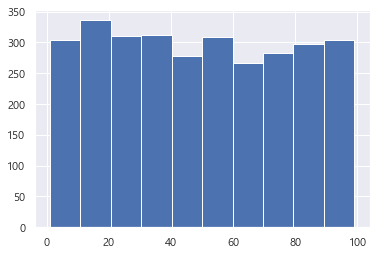

In [3]:
# 히스토그램으로 생성된 데이터 분포 확인
plt.hist(data)
plt.show()

49.13466666666667
28.724516791216676


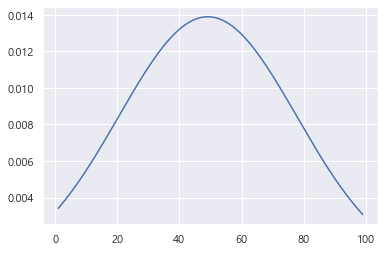

In [4]:
# Data의 정규분포 확인
data_mean = np.mean(data)
data_std = np.std(data)

print(data_mean)
print(data_std)

# 확률밀도 함수 생성
pdf = stats.norm.pdf(np.sort(data), data_mean, data_std)

plt.figure()
plt.plot(np.sort(data), pdf)

-3.967196941327226e-17
1.0


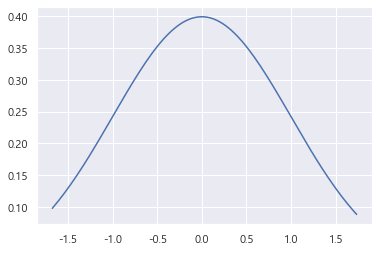

In [5]:
# 표준정규분포(Z분포)로 변환
std_list = []

for i in data :
    z = (i - data_mean) / data_std
    std_list.append(z)
    
ol_data_mean = np.mean(std_list)
ol_data_std = np.std(std_list)

print(ol_data_mean)
print(ol_data_std)

ol_pdf = stats.norm.pdf(np.sort(std_list), 
                       ol_data_mean, ol_data_std)

plt.figure()
plt.plot(np.sort(std_list), ol_pdf)

## 2) 데이터셋에 이상값 추가

49.350830564784054
29.1834586728082


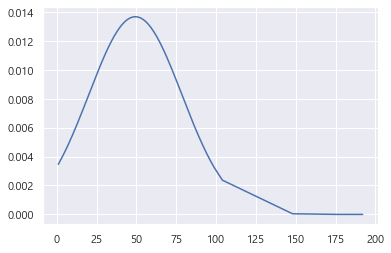

In [6]:
# 이상값 추가

ol_data = data.copy()
ol_no = 10

for i in range(ol_no) :
    rand_no = random.randint(0, len(data))
    ol_data.insert(rand_no, ol_data[rand_no]*2) # 이상값 생성
    
# 이상값이 추가된 데이터의 정규분포도
ol_data_mean = np.mean(ol_data)
ol_data_std = np.std(ol_data)

print(ol_data_mean)
print(ol_data_std)

ol_pdf = stats.norm.pdf(np.sort(ol_data),
                       ol_data_mean, ol_data_std)

plt.figure()
plt.plot(np.sort(ol_data), ol_pdf)

-3.9540168850437467e-17
1.0


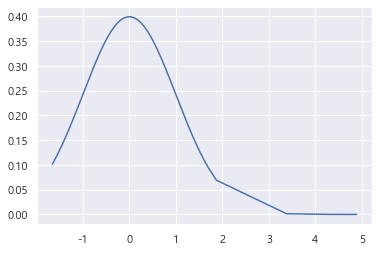

In [7]:
# 이상값 추가된 데이터의 표준화

ol_std_list = []

for i in ol_data :
    z = (i - ol_data_mean) / ol_data_std
    ol_std_list.append(z)
    
ol_st_data_mean = np.mean(ol_std_list)
ol_st_data_std = np.std(ol_std_list)

print(ol_st_data_mean)
print(ol_st_data_std)

ol_std__pdf = stats.norm.pdf(np.sort(ol_std_list),
                            ol_st_data_mean, ol_st_data_std)

plt.figure()
plt.plot(np.sort(ol_std_list), ol_std__pdf)

## 3) Z값의 2가 넘어 가는 데이터 삭제

In [8]:
# 전체 라인수 확인
len(ol_std_list)

3010

In [10]:
# -2 ~ 2 범위 벗어나면 이상값으로 제거

for i in ol_std_list :
    z = i
    if z > 2 :
        ol_std_list.remove(z)
    if z < -2 :
        ol_std_list.remove(z)

In [11]:
# 이상값 제거 후 라인수
len(ol_std_list)

3005

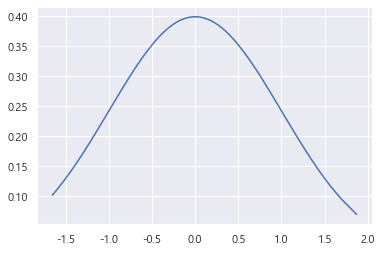

In [12]:
# 이상값 제거 후 표준정규분포 확인
ol_std_pdf = stats.norm.pdf(np.sort(ol_std_list), ol_st_data_mean, ol_st_data_std)

plt.figure()
plt.plot(np.sort(ol_std_list), ol_std_pdf)

# 3. 사분위수 범위로 이상값 제거
## 1) dltkdrkqt epdlxj todtjd

In [13]:
# 이상값 데이터 생성
boxdata = pd.DataFrame(np.random.randn(100, 3), columns=['A열', 'B열', 'C열'])

In [14]:
boxdata.head()

,A열,B열,C열
0,-0.920631,0.244954,-0.251617
1,0.120701,-0.296330,-0.384125
2,-0.070728,2.231144,0.908281
3,1.025684,-0.271475,-0.774608
4,0.129499,-0.136303,2.056957


## 2) 이상값 데이터 확인

In [15]:
# 기술통계 정보로 pencentile 확인
boxdata.describe()

,A열,B열,C열
count,100.000000,100.000000,100.000000
mean,-0.078337,0.008609,0.104468
std,0.830135,0.902578,1.012958
min,-2.587718,-2.111079,-2.703632
25%,-0.578654,-0.548731,-0.443562
50%,-0.034377,0.031143,0.022304
75%,0.434056,0.575261,0.802881
max,1.919801,2.231144,2.759922


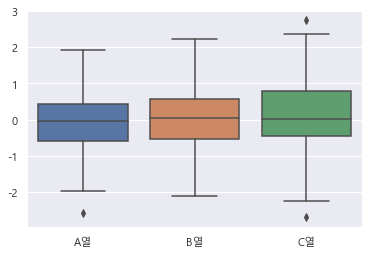

In [16]:
# 박스 플롯을 이용한 이상값 확인
sns.boxplot(data = boxdata)
plt.show()

## 2) 이상값 확인

In [39]:
#이상값 계산하는 함수
def get_outlier(df=None, column=None, weight=1.5) :
    quantile_25 = np.percentile(df[column].values, 25)
    quantile_75 = np.percentile(df[column].values, 75)
    
    IQR = quantile_75 - quantile_25
    IQR_weight = IQR * weight
    
    lowest = quantile_25 - IQR_weight
    highest = quantile_75 + IQR_weight
    
    outlier_idx = df[column][(df[column] < lowest) | (df[column] > highest)].index
    return outlier_idx

In [40]:
# 함수 사용해서 이상값 확인
outlier_idx = get_outlier(df=boxdata, column='B열', weight=1.5)

In [41]:
outlier_idx

Int64Index([2], dtype='int64')

In [42]:
# 이상값 삭제
boxdata.drop(outlier_idx, axis=0, inplace=True)

In [43]:
boxdata.shape

(98, 3)

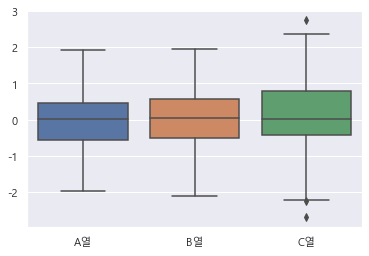

In [44]:
# 박스플롯을 이용한 이상값 확인
sns.boxplot(data = boxdata)
plt.show()

(98, 3)


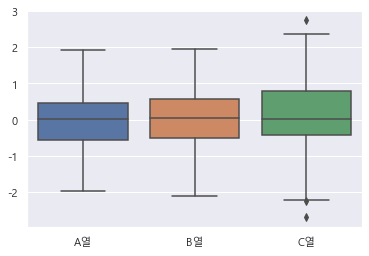

In [45]:
# 함수 사용해서 이상값 확인
outlier_idx = get_outlier(df=boxdata, column='A열', weight=1.5)
5ttt
outlier_idx

# 이상값 삭제
boxdata.drop(outlier_idx, axis=0, inplace=True)

print(boxdata.shape)

# 박스플롯을 이용한 이상값 확인
sns.boxplot(data = boxdata)
plt.show()

(95, 3)


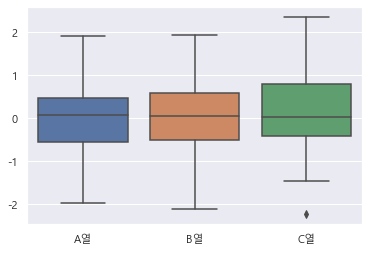

In [46]:
# 함수 사용해서 이상값 확인
outlier_idx = get_outlier(df=boxdata, column='C열', weight=1.5)

outlier_idx

# 이상값 삭제
boxdata.drop(outlier_idx, axis=0, inplace=True)

print(boxdata.shape)

# 박스플롯을 이용한 이상값 확인
sns.boxplot(data = boxdata)
plt.show()

(94, 3)


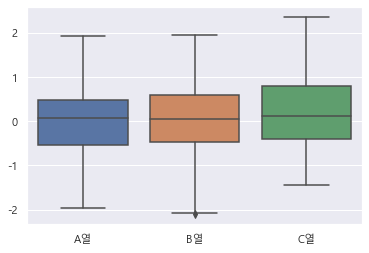

In [47]:
# 함수 사용해서 이상값 확인
outlier_idx = get_outlier(df=boxdata, column='C열', weight=1.5)

outlier_idx

# 이상값 삭제
boxdata.drop(outlier_idx, axis=0, inplace=True)

print(boxdata.shape)

# 박스플롯을 이용한 이상값 확인
sns.boxplot(data = boxdata)
plt.show()

In [ ]:
##### 함수 사용해서 이상값 확인
outlier_idx = get_outlier(df=boxdata, column='B열', weight=1.5)

outlier_idx

# 이상값 삭제
boxdata.drop(outlier_idx, axis=0, inplace=True)

print(boxdata.shape)

# 박스플롯을 이용한 이상값 확인
sns.boxplot(data = boxdata)
plt.show()